In [16]:
import pandas as pd 
import wandb
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("dl-coding/hydrogen-prediction")

summary_list, config_list, name_list = [], [], []
for run in runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
          if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list
    })

In [6]:
runs_df.head()

,summary,config,name
0,"{'avg_binding_length': 0.03731993643006426, 'a...","{'random_seed': 42, 'train_data_path': 'datase...",linear_regression
1,"{'R2': -4.696044381950296e-05, '_wandb': {'run...","{'random_seed': 42, 'train_data_path': 'datase...",lasso_regression_alpha_1
2,"{'_runtime': 2.100187301635742, '_timestamp': ...","{'random_seed': 42, 'train_data_path': 'datase...",lasso_regression_alpha_0.1
3,"{'R2': 0.9514748857471116, 'MSE': 0.0196284246...","{'random_seed': 42, 'train_data_path': 'datase...",lasso_regression_alpha_0.01
4,"{'_wandb': {'runtime': 0}, '_runtime': 2.08693...","{'random_seed': 42, 'train_data_path': 'datase...",lasso_regression_alpha_0.001


In [7]:
#runs_df.to_csv("../data/wandb_training_runs.csv")

# "Unfold" the dataframe

In [9]:
# Create DataFrames from the summary and config lists
summary_df = pd.json_normalize(summary_list)
config_df = pd.json_normalize(config_list)

# Combine the summary, config, and name DataFrames
runs_df = pd.concat([summary_df, config_df], axis=1)
runs_df['name'] = name_list

In [10]:
runs_df.head()

,avg_binding_length,avg_cosine_similarity,R2,_step,_runtime,model_name,MSE,_timestamp,tri-angle_wasserstein_distance,_wandb.runtime,random_seed,train_data_path,name
0,0.037320,5.370280,0.954251,0,2.254910,linear_regression,0.018505,1.720485e+09,1.920062,0,42,dataset-C4-depth1,linear_regression
1,1.094925,89.556962,-0.000047,0,2.085228,lasso_regression_alpha_1,0.404704,1.720485e+09,33.273237,0,42,dataset-C4-depth1,lasso_regression_alpha_1
2,0.633182,5.548139,0.656043,0,2.100187,lasso_regression_alpha_0.1,0.139188,1.720485e+09,1.999316,0,42,dataset-C4-depth1,lasso_regression_alpha_0.1
3,0.097059,5.376588,0.951475,0,2.124343,lasso_regression_alpha_0.01,0.019628,1.720485e+09,1.935071,0,42,dataset-C4-depth1,lasso_regression_alpha_0.01
4,0.043479,5.358138,0.954288,0,2.086938,lasso_regression_alpha_0.001,0.018489,1.720485e+09,1.927583,0,42,dataset-C4-depth1,lasso_regression_alpha_0.001


In [12]:
# Group the DataFrame by 'train_data_path'
grouped = runs_df.groupby('train_data_path')

Creating plots for dataset: dataset-C4-depth1


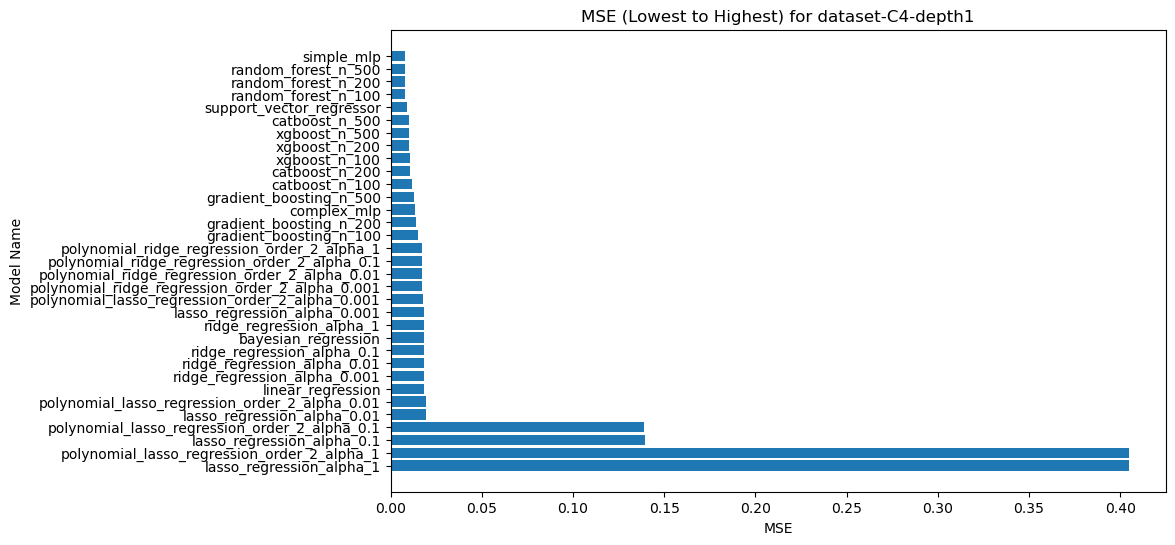

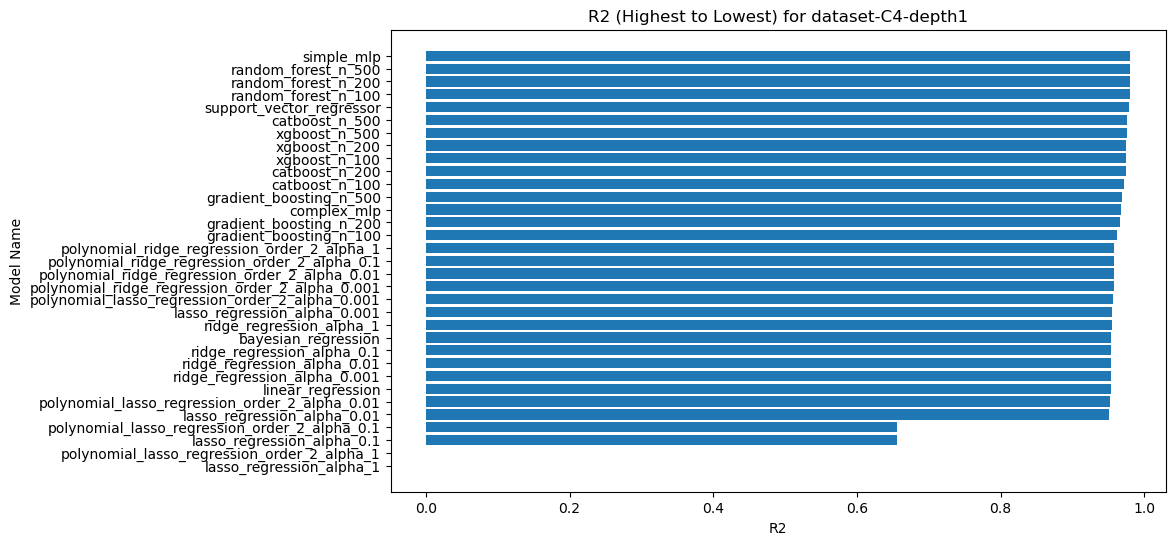

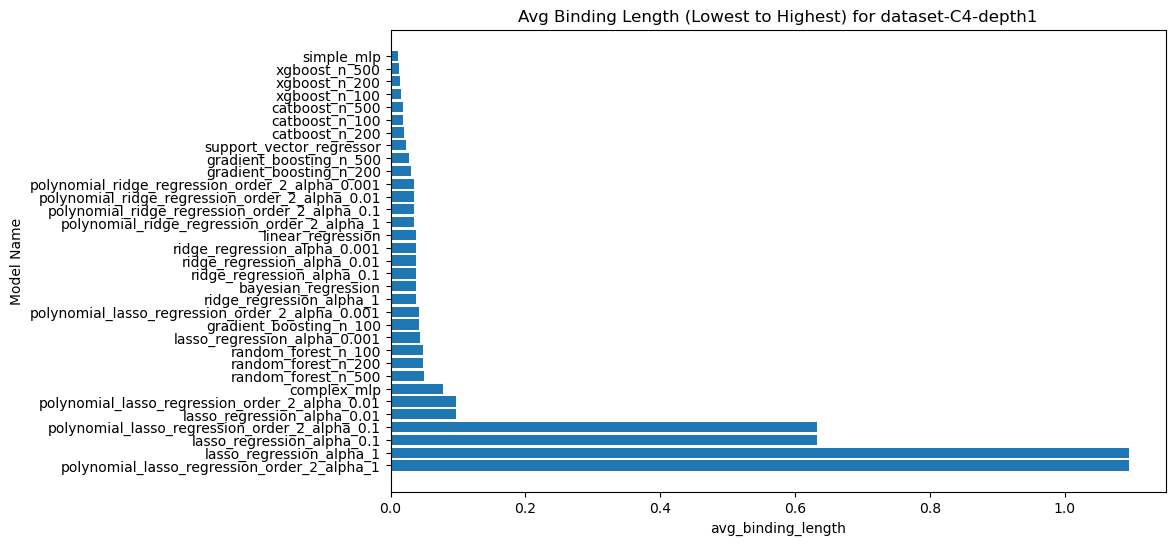

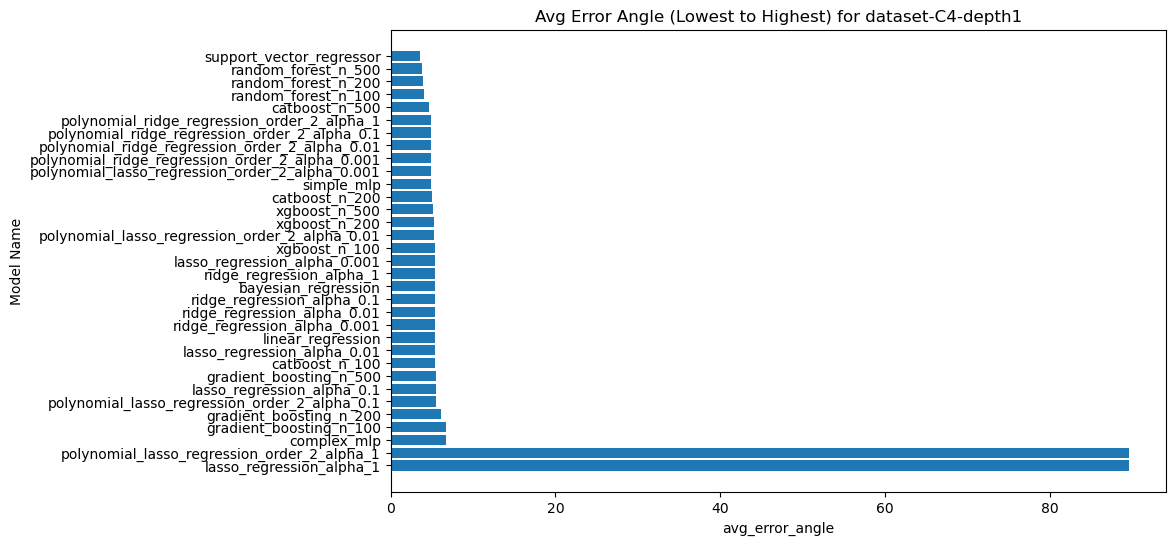

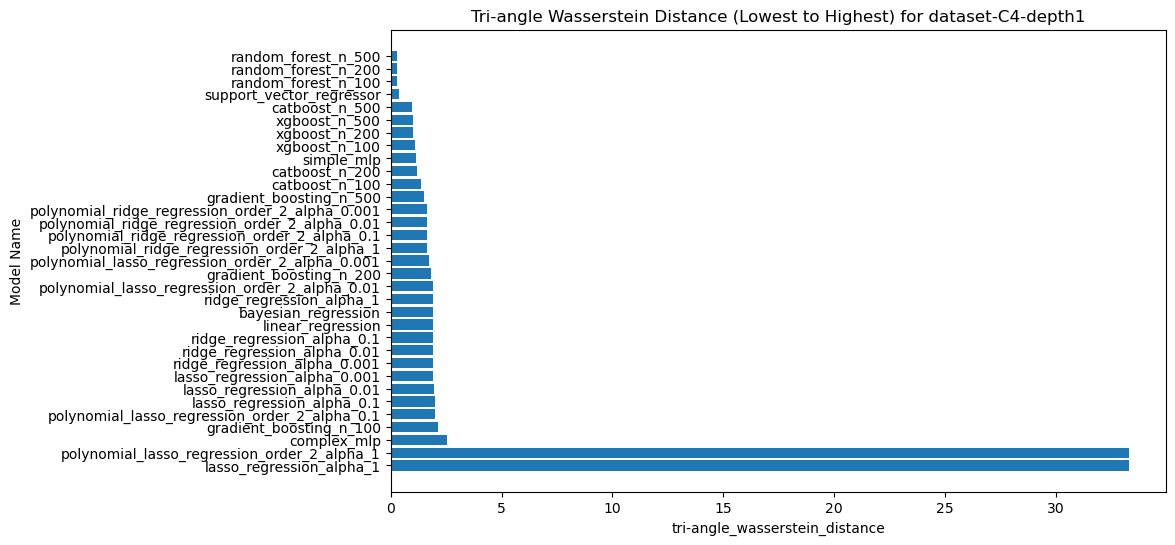

Creating plots for dataset: dataset-C4-depth2


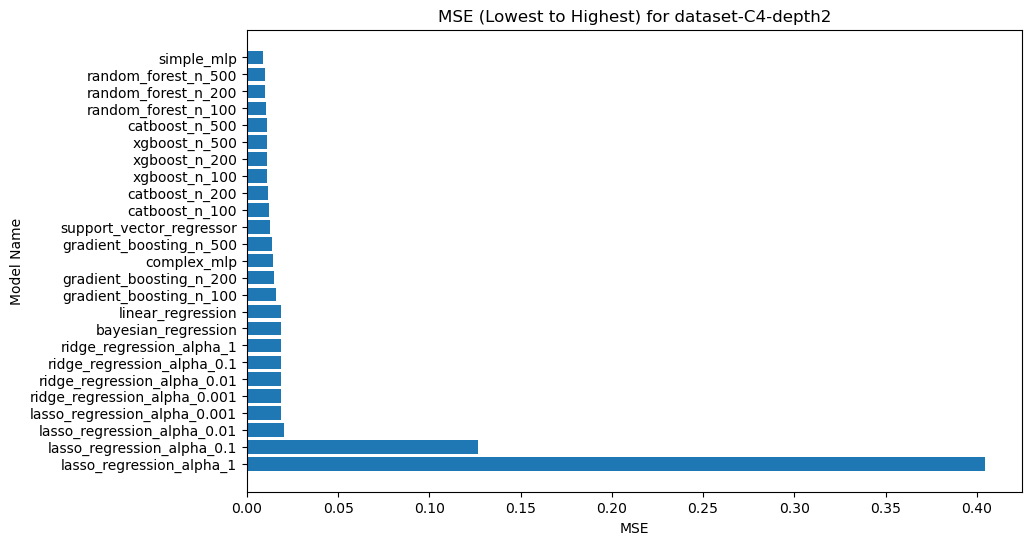

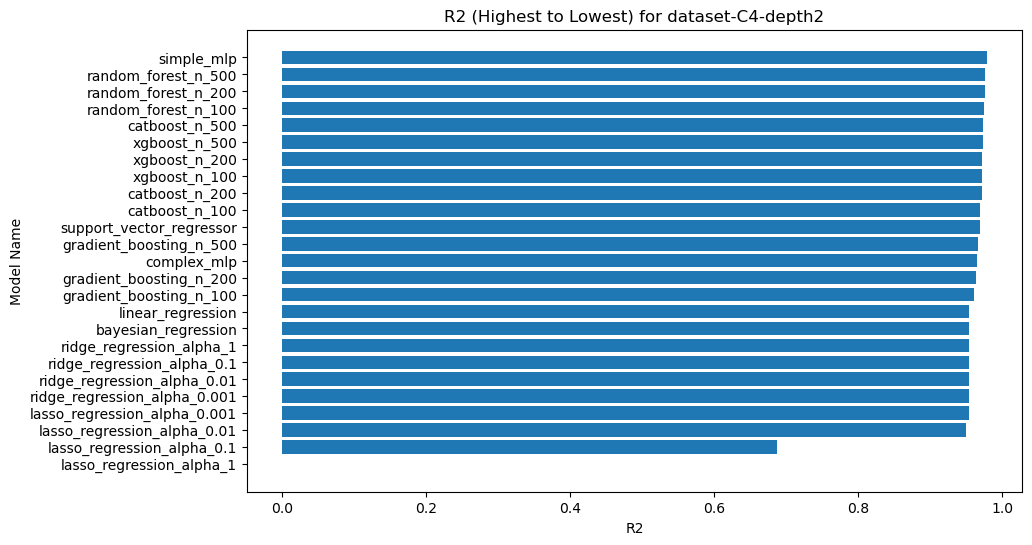

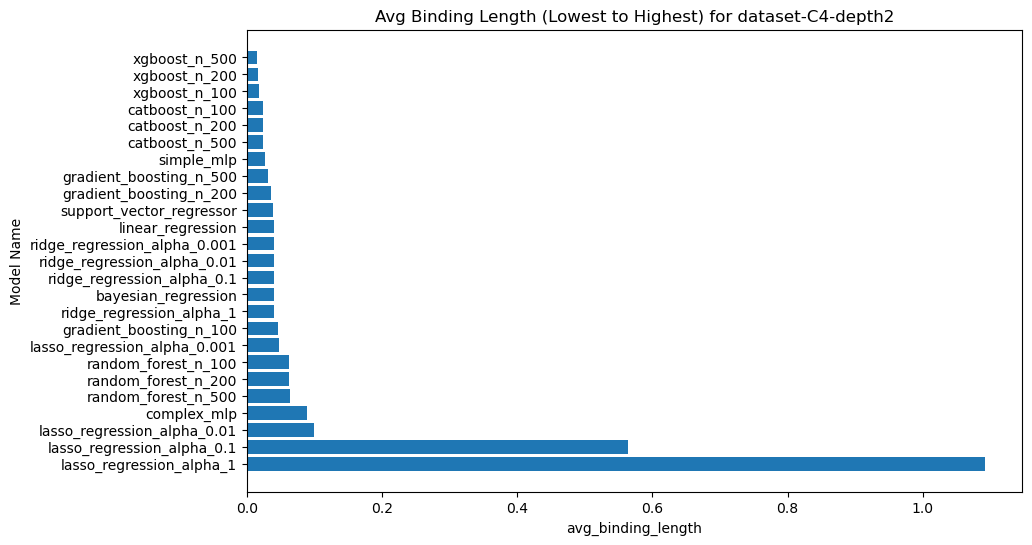

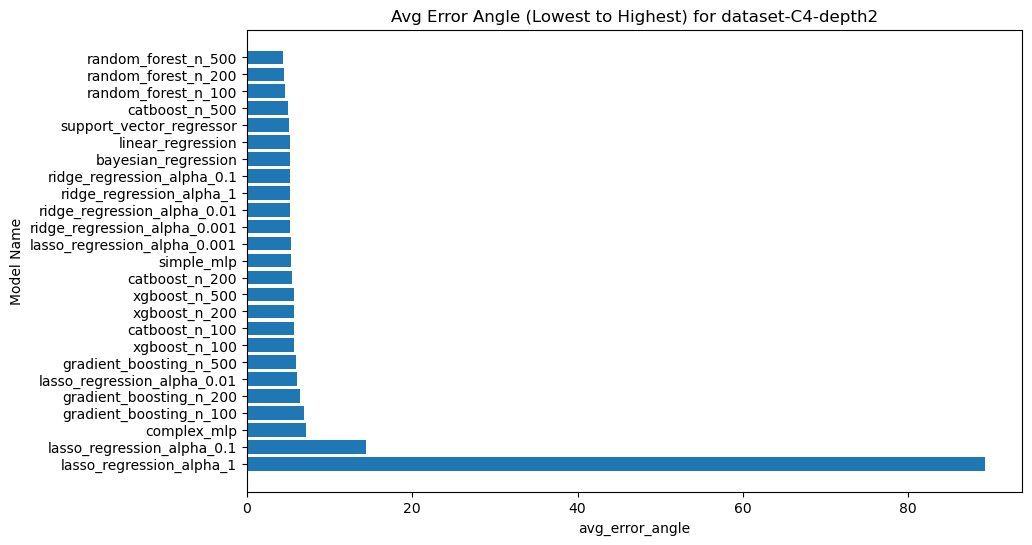

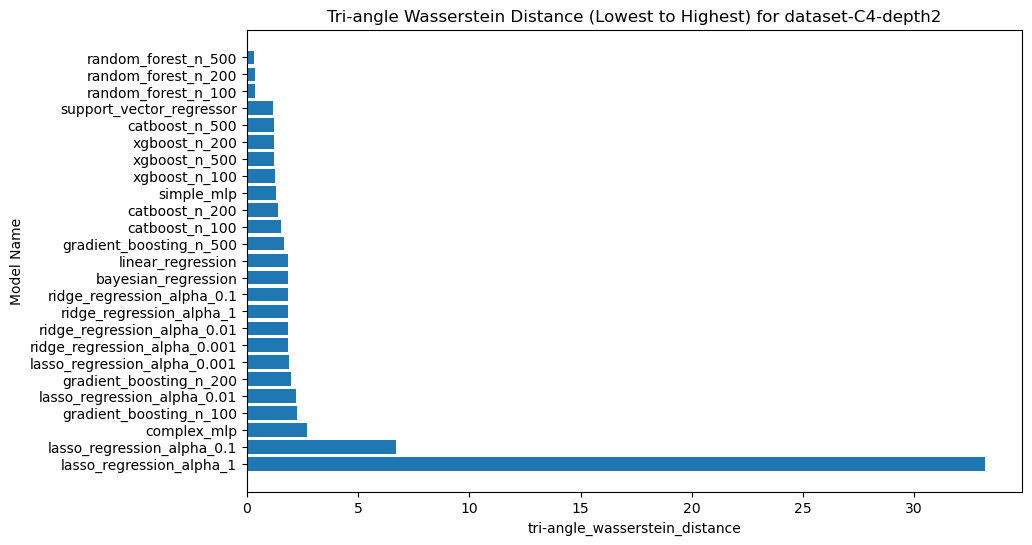

Creating plots for dataset: dataset-O2-depth1


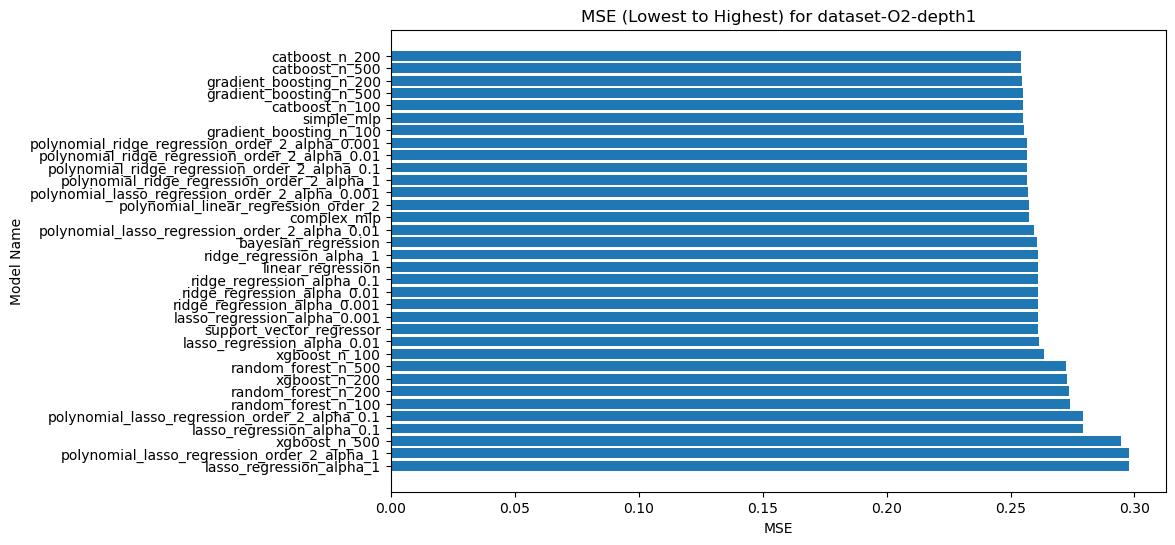

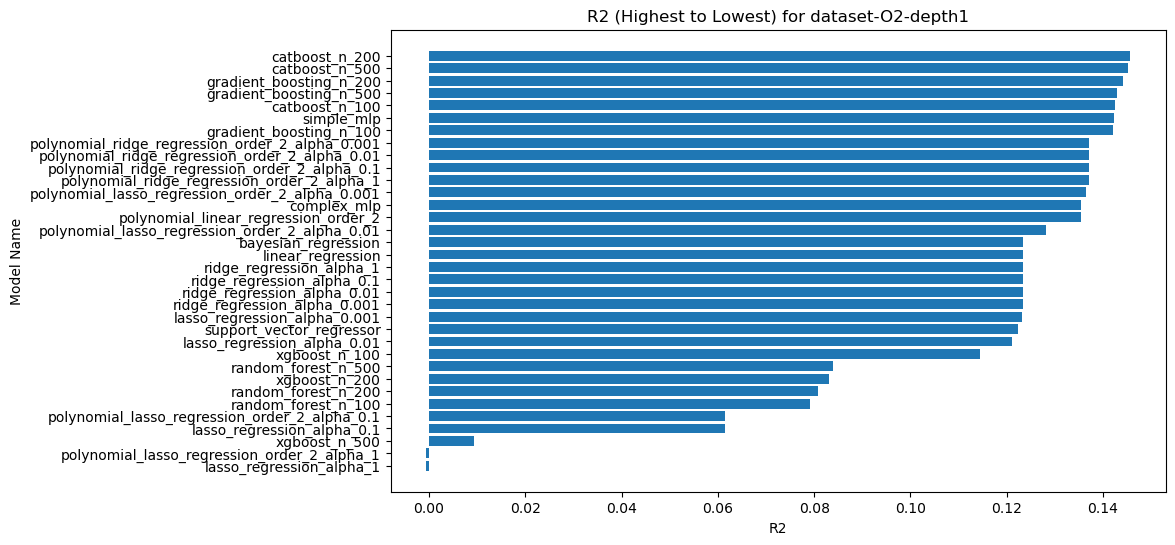

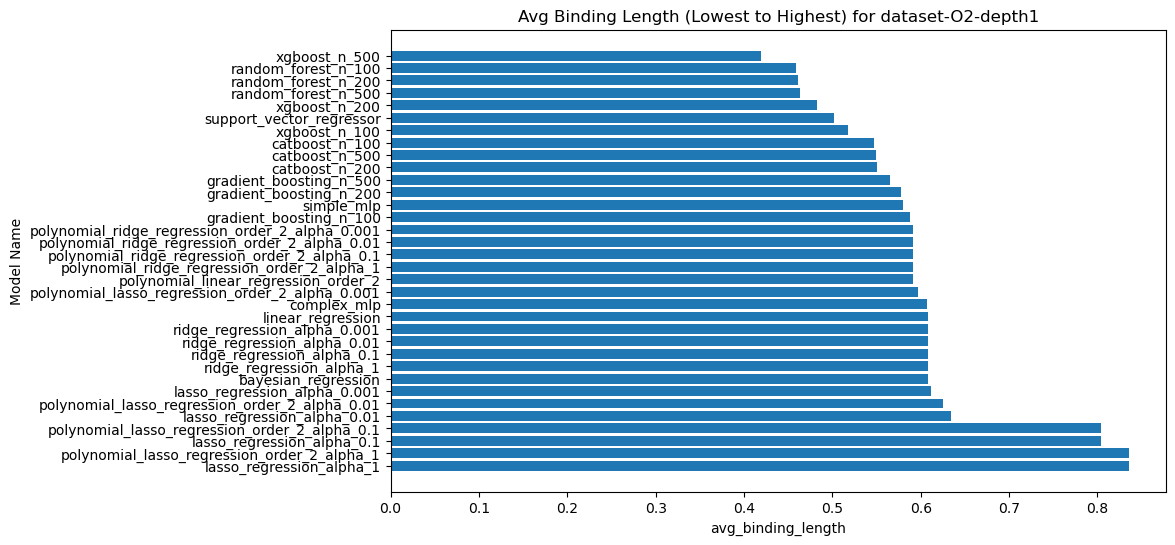

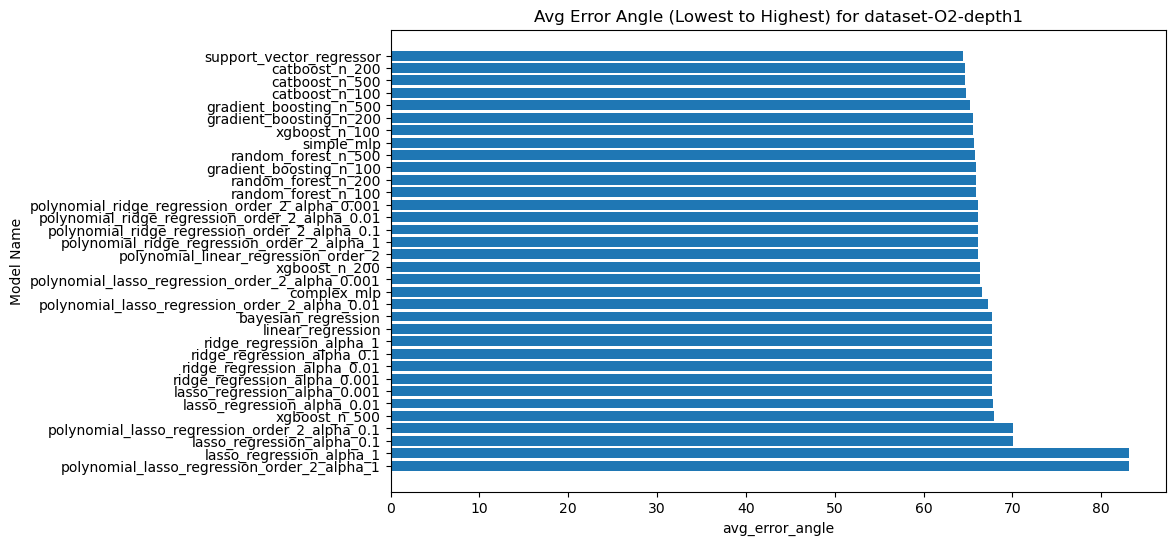

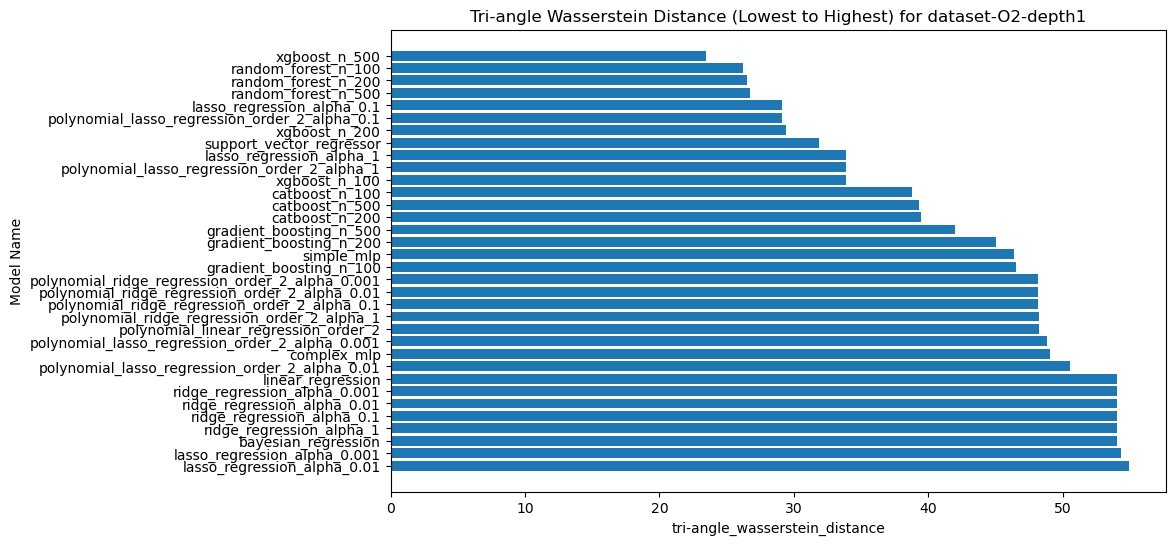

Creating plots for dataset: dataset-O2-depth2


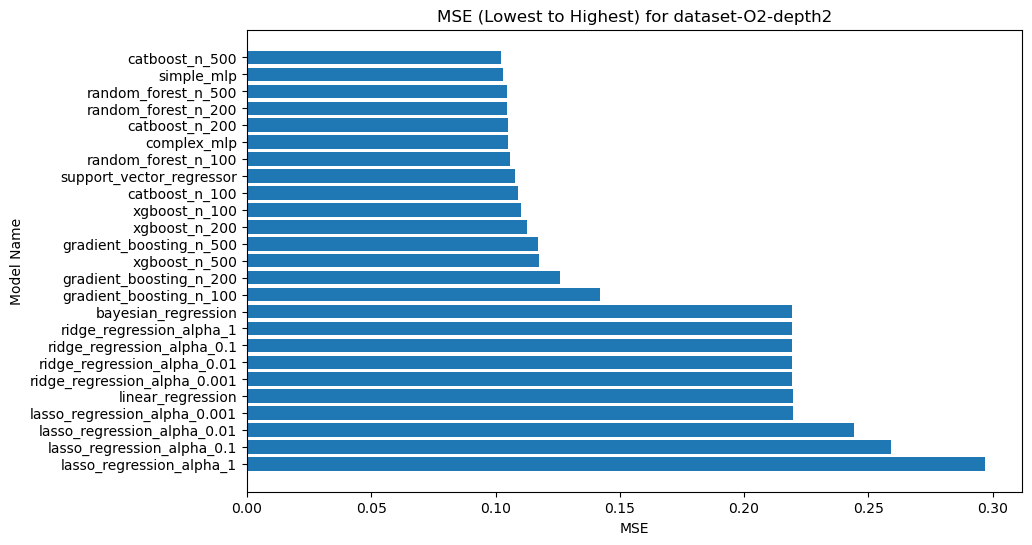

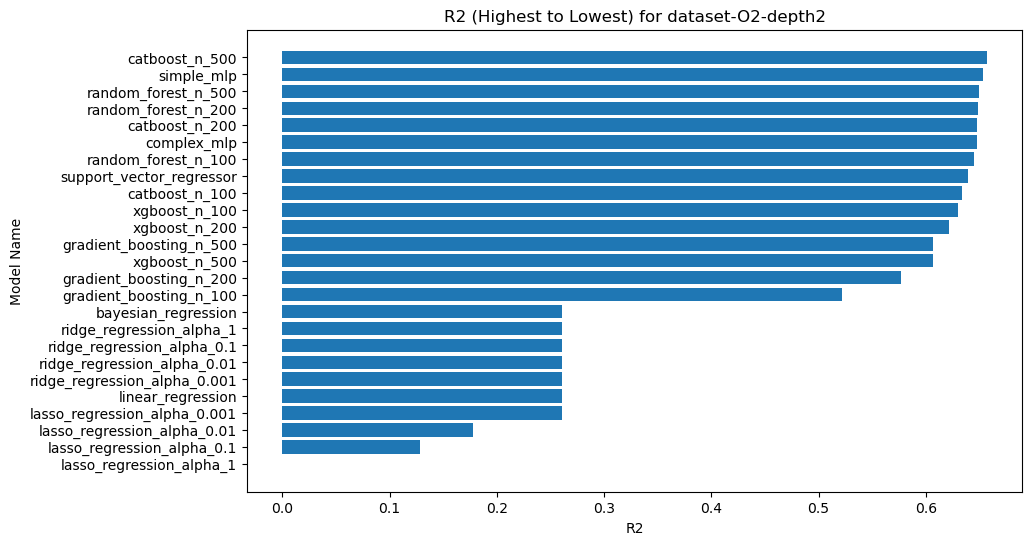

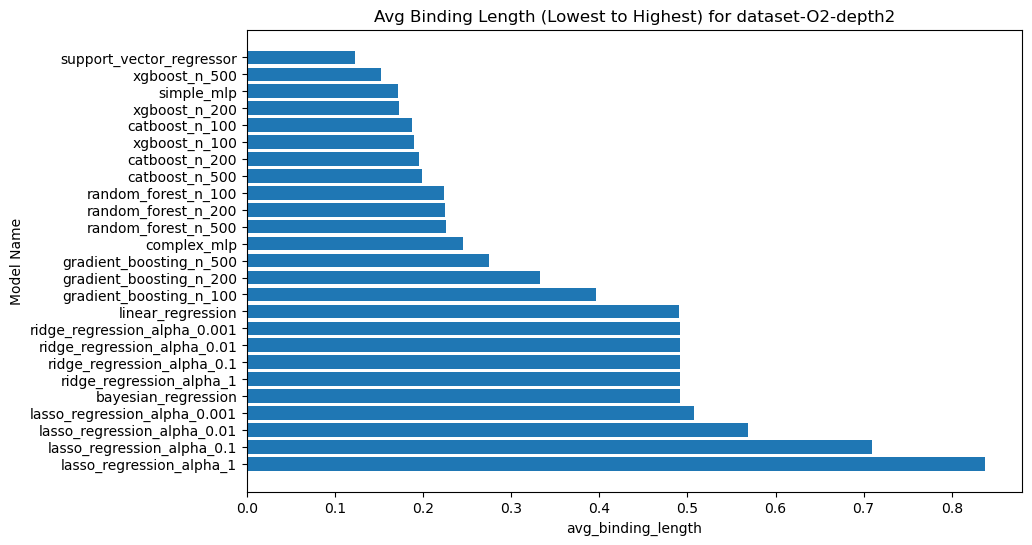

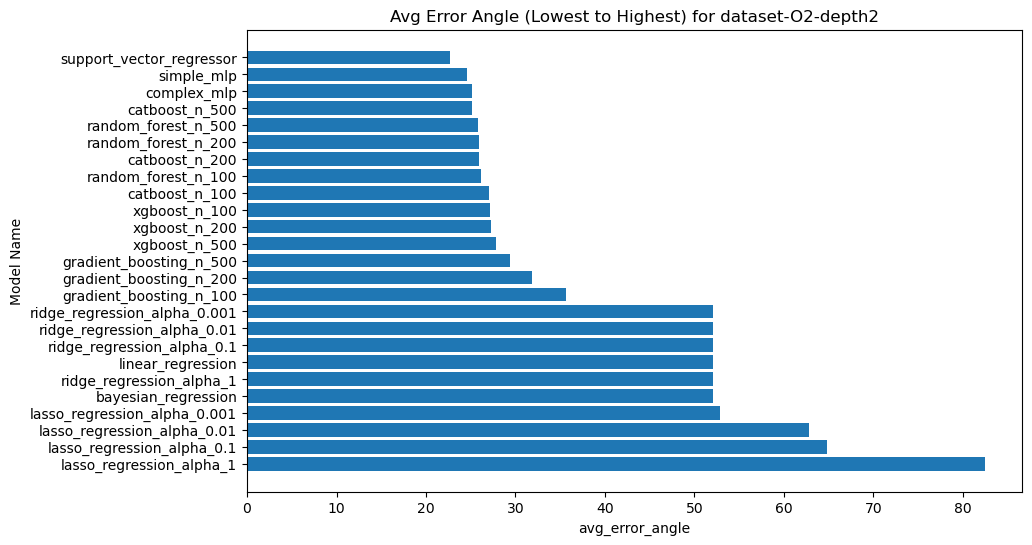

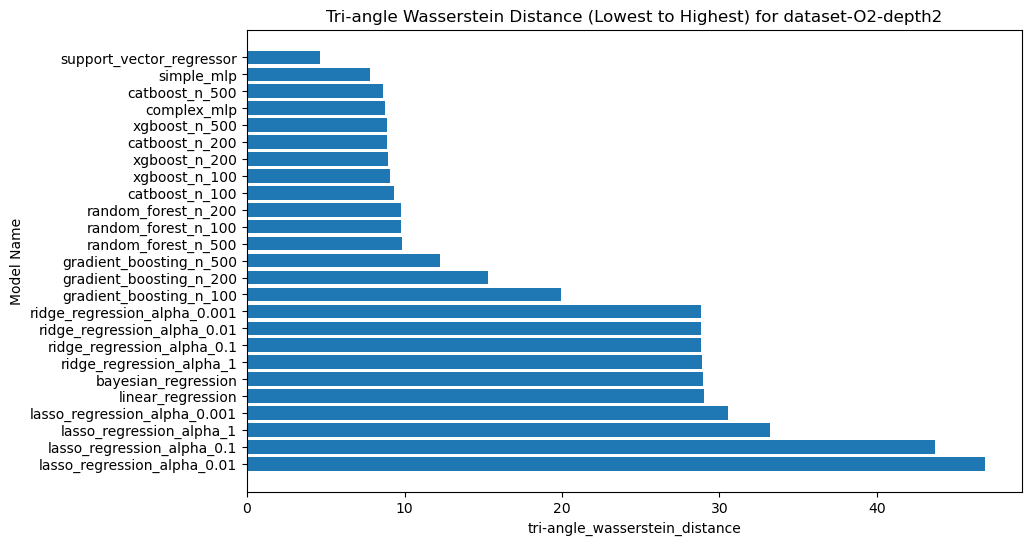

In [28]:
# Define a function to create and show horizontal bar plots
def create_bar_plot(group, metric, title, ascending):
    sorted_group = group.sort_values(by=metric, ascending=ascending)
    plt.figure(figsize=(10, 6))
    plt.barh(sorted_group['name'], sorted_group[metric])
    if metric == "avg_cosine_similarity":
        plt.xlabel("avg_error_angle")
    else:
        plt.xlabel(metric)
    plt.ylabel('Model Name')
    train_data_path = group["train_data_path"].iloc[0]
    plt.title(f'{title} for {train_data_path}')
    plt.savefig(f"../img/training/{train_data_path}/{metric}.png", bbox_inches='tight')
    plt.show()

# For each dataset group, create the specified plots
for train_data_path, group in grouped:
    if train_data_path == "dataset-C4-depth1":
        group = group[group['name'] != 'polynomial_linear_regression_order_2']
        
    print(f"Creating plots for dataset: {train_data_path}")
    create_bar_plot(group, 'MSE', 'MSE (Lowest to Highest)', ascending=False)
    create_bar_plot(group, 'R2', 'R2 (Highest to Lowest)', ascending=True)
    create_bar_plot(group, 'avg_binding_length', 'Avg Binding Length (Lowest to Highest)', ascending=False)
    create_bar_plot(group, 'avg_cosine_similarity', 'Avg Error Angle (Lowest to Highest)', ascending=False)
    create_bar_plot(group, 'tri-angle_wasserstein_distance', 'Tri-angle Wasserstein Distance (Lowest to Highest)', ascending=False)

In [43]:
# Initialize a dictionary to store rankings per dataset
rankings = {}

# For each dataset group, create the specified plots and calculate ranks
best_models = {}

for train_data_path, group in grouped:
    # Rank models for each metric
    group['rank_MSE'] = group['MSE'].rank(ascending=True)
    group['rank_R2'] = group['R2'].rank(ascending=False)
    group['rank_avg_binding_length'] = group['avg_binding_length'].rank(ascending=True)
    group['rank_avg_cosine_similarity'] = group['avg_cosine_similarity'].rank(ascending=True)
    group['rank_tri_angle_wasserstein_distance'] = group['tri-angle_wasserstein_distance'].rank(ascending=True)
    
    # Calculate average rank
    group['average_rank'] = group[['rank_MSE', 'rank_R2', 'rank_avg_binding_length', 'rank_avg_cosine_similarity', 'rank_tri_angle_wasserstein_distance']].mean(axis=1)

    # Create a list of (name, average rank) tuples
    ranking_list = list(zip(group['name'], group['average_rank']))

    # Sort the list by average rank
    ranking_list.sort(key=lambda x: x[1])

    # Store the ranking list in the rankings dictionary
    rankings[train_data_path] = ranking_list

    # Identify the best model
    best_model = group.loc[group['average_rank'].idxmin()]
    best_models[train_data_path] = best_model['name']

    print(f"Best model for {train_data_path}: {best_model['name']} with average rank {best_model['average_rank']}")

Best model for dataset-C4-depth1: support_vector_regressor with average rank 4.6
Best model for dataset-C4-depth2: catboost_n_500 with average rank 5.0
Best model for dataset-O2-depth1: catboost_n_200 with average rank 5.6
Best model for dataset-O2-depth2: simple_mlp with average rank 2.2


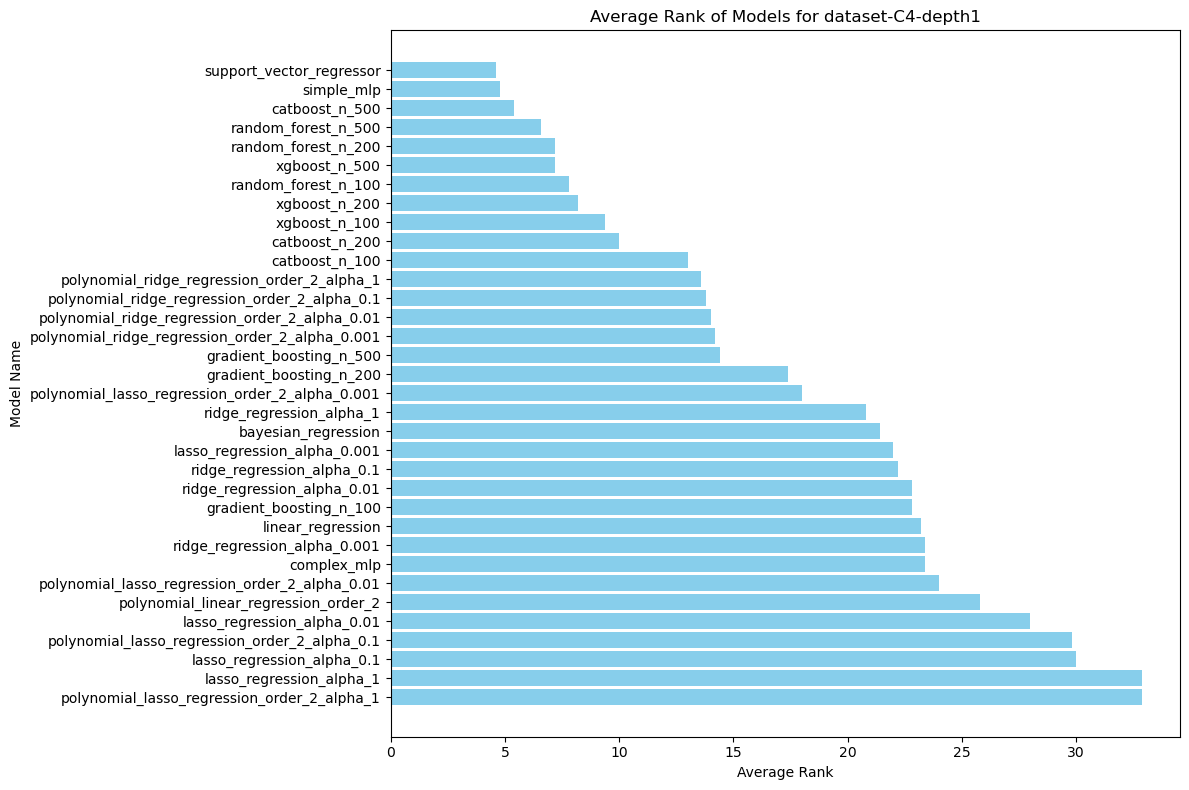

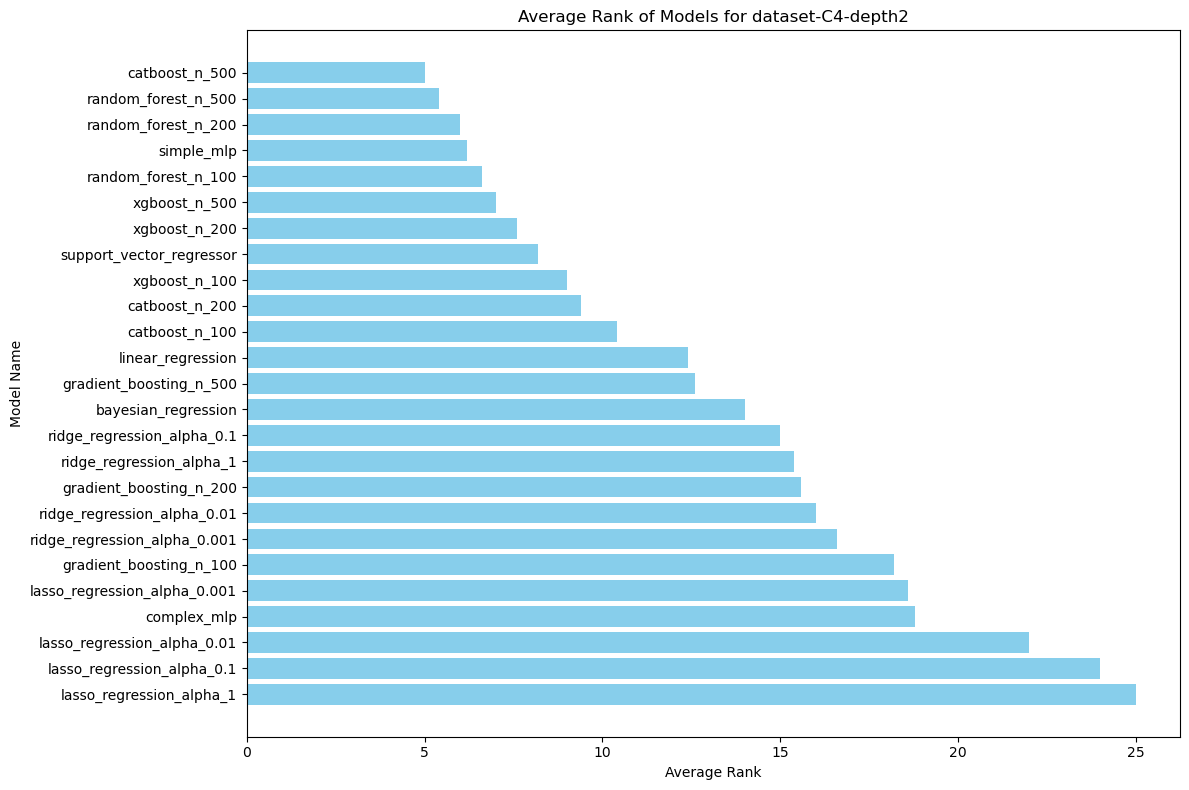

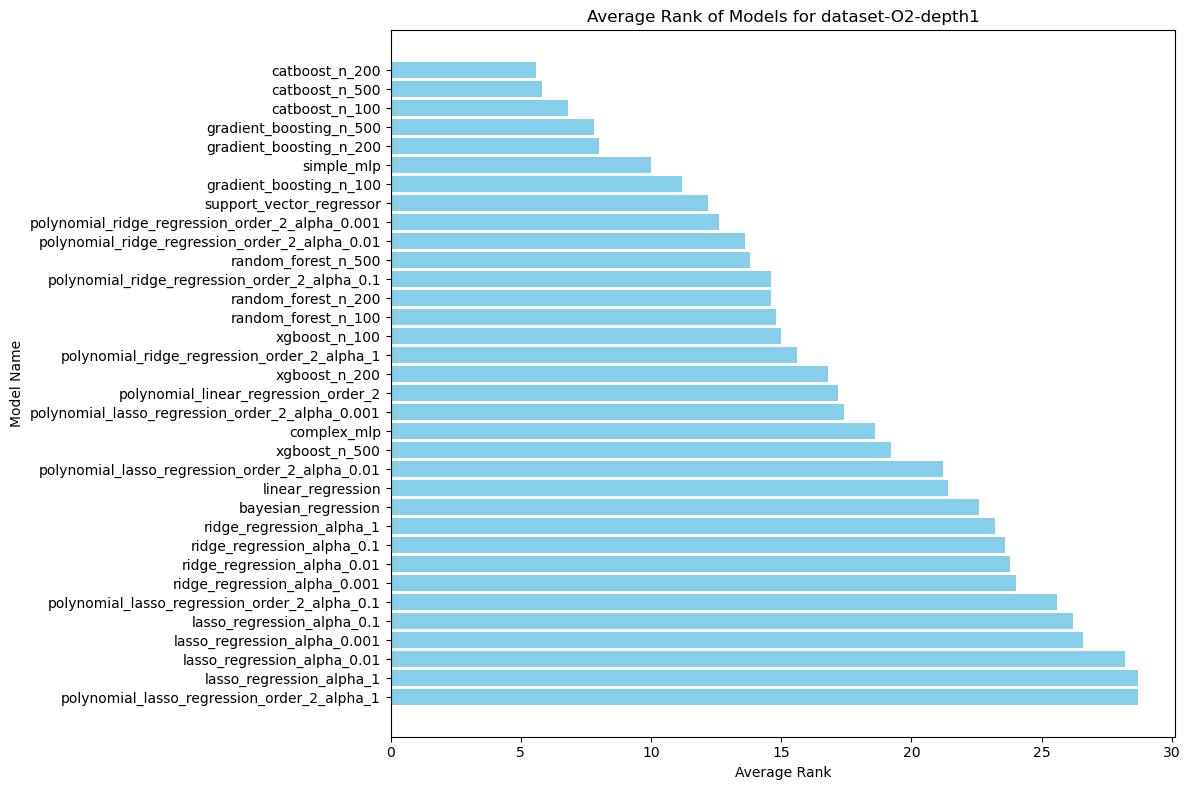

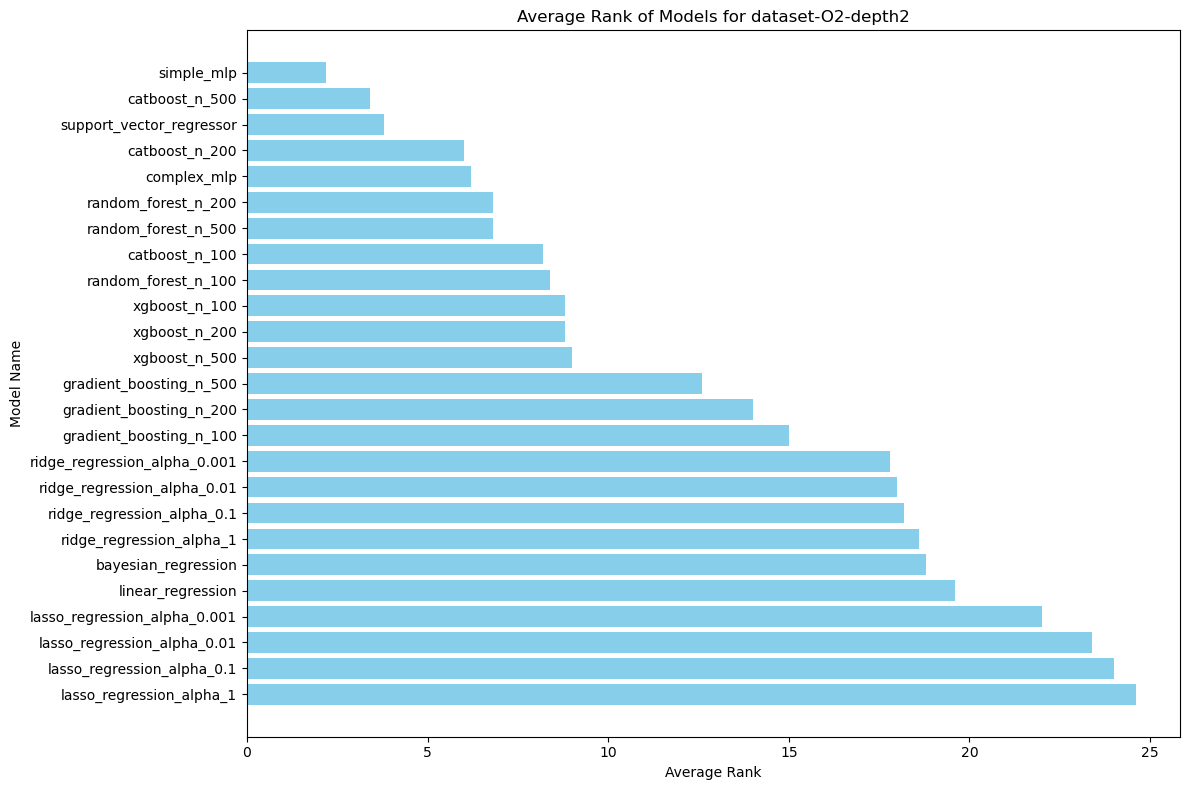

In [44]:
import matplotlib.pyplot as plt

# Function to plot rankings for each dataset
def plot_rankings(rankings):
    for dataset, ranking_list in rankings.items():
        names, avg_ranks = zip(*ranking_list)
        plt.figure(figsize=(12, 8))
        plt.barh(names, avg_ranks, color='skyblue')
        plt.xlabel('Average Rank')
        plt.ylabel('Model Name')
        plt.title(f'Average Rank of Models for {dataset}')
        plt.gca().invert_yaxis()  # Invert y-axis to have the best rank at the top
        plt.tight_layout()
        
        # Save the plot with a bounding box
        plt.savefig(f"../img/training/{dataset}/ranking.png", bbox_inches='tight')
        plt.show()

# Call the function to plot the rankings
plot_rankings(rankings)